In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
from sklearn.cross_validation import train_test_split
import string
%matplotlib inline 

/Users/Lucy/anaconda/envs/capstone/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
mypath = '/Users/Lucy/Google Drive/MSDS/2016Fall/DSGA1006/Data'
orgs = pd.read_csv(mypath + '/csv_export/organizations.csv')
df = pd.read_csv(mypath + '/unsupervised/clustering_data.csv',index_col = 0,encoding = 'utf8')
cats = pd.read_csv(mypath + '/csv_export/category_groups.csv')

/Users/Lucy/anaconda/envs/capstone/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,company_uuid,company_name,company_category_list,category_group_list,short_description,description,founded_on
0,2593028d-6633-21c4-6eb0-fa483675754c,Apsiyon,SaaS|Software,software,Online residence property management,Apsiyon is an internet startup offering softwa...,2011-06-01
1,fe57be45-36ee-ed64-289a-a06ac3f10142,Fastudent,Education,education,Fastudent is the largest education portal in I...,Our mission is to provide efficient and effect...,2013-01-01
2,6948c23e-1c82-6813-997f-d68dadd1aba4,Kalaage Creations Pvt Ltd,Social Network,NaN,A social network for writers and publications ...,A social network for writers and publications ...,2015-03-14
3,a2cbba96-bddd-09a2-76a8-9926b847faea,Lydia,Apps|FinTech|Mobile Payments|Software,apps|financial services|mobile|payments|software,Lydia's iPhone and Android apps enable you to ...,Lydia's iPhone and Android apps enable you to ...,2013-06-01
4,231686ac-6311-465d-d96c-267505d7824a,Owtware,Cyber Security|Enterprise Software|Virtualization,hardware|information technology|privacy and se...,Web-scale enterprise private cloud platform,Web-scale enterprise private cloud platform.,2011-12-11


In [4]:
cats[cats.category_name == 'analytics']

,uuid,category_name,category_group_list
24,99c5404c-0ff5-8ee5-d334-4b944ddb8cd9,analytics,data and analytics


In [5]:
# remove companies without categories

company_cat_df = df[df.company_category_list.notnull()].copy()
cat_group_df = df[df.category_group_list.notnull()].copy()

In [6]:
[pos for pos, char in enumerate(company_cat_df.company_category_list[3]) if char == '|']

[4, 12, 28]

In [7]:
company_cat_df['cat_count'] = company_cat_df.company_category_list.apply(lambda x: 
                                                            len([pos for pos, char in enumerate(x) if char == '|']))
company_cat_df['trunc_company_category_list'] = company_cat_df.company_category_list
company_cat_df['cat_list'] = company_cat_df.trunc_company_category_list.apply(lambda x: x.split('|'))
company_cat_df['trunc_company_category_list'] = company_cat_df.cat_list.apply(lambda x:
                                                                             x[0] + '|' + x[1]
                                                                             if len(x) > 1
                                                                             else x[0])
company_cat_df['trunc_company_category_list_2'] = company_cat_df.cat_list.apply(lambda x: x[0])

In [8]:
company_cat_df.trunc_company_category_list_2.nunique()

601

In [9]:
company_cat_df.trunc_company_category_list.nunique()

11207

In [10]:
company_cat_df.company_category_list.nunique()

29419

In [11]:
company_cat_df.groupby('trunc_company_category_list')['company_uuid'].count().nsmallest(10)

trunc_company_category_list
3D Printing|Advertising                1
3D Printing|Analytics                  1
3D Printing|Apps                       1
3D Printing|Artificial Intelligence    1
3D Printing|Augmented Reality          1
3D Printing|Automotive                 1
3D Printing|Beauty                     1
3D Printing|Big Data                   1
3D Printing|Building Material          1
3D Printing|CRM                        1
Name: company_uuid, dtype: int64

In [12]:
categories = pd.DataFrame(company_cat_df.groupby('trunc_company_category_list')['company_uuid'].count()).reset_index()

In [13]:
categories['new_category'] = categories.trunc_company_category_list.apply(lambda x: x.split('|')[0])

In [14]:
cat_group_df['cat_count'] = cat_group_df.category_group_list.apply(lambda x: 
                                                            len([pos for pos, char in enumerate(x) if char == '|']))
cat_group_df['trunc_category_group_list'] = cat_group_df.category_group_list.apply(lambda x: x.split('|'))
cat_group_df['trunc_category_group_list'] = cat_group_df.trunc_category_group_list.apply(lambda x:
                                                                             x[0] + '|' + x[1]
                                                                             if len(x) > 1
                                                                             else x[0])
cat_group_df['trunc_category_group_list_2'] = cat_group_df.trunc_category_group_list.apply(lambda x:
                                                                             x[0])

In [15]:
cat_group_df['trunc_category_group_list_2'].nunique()

15

In [16]:
cat_group_df.trunc_category_group_list.nunique()

655

## use just the first company category for labels

In [17]:
labels = pd.DataFrame(company_cat_df.trunc_company_category_list_2.unique()).reset_index()
labels.columns = ['num_label','label']

In [18]:
company_cat_df = company_cat_df.merge(labels[['num_label', 'label']], left_on=['trunc_company_category_list_2'],
                                     right_on = 'label')

In [19]:
lstm_data = company_cat_df[['company_uuid','company_name','short_description','description','label']].copy()

In [20]:
lstm_data.head()

,company_uuid,company_name,short_description,description,label
0,2593028d-6633-21c4-6eb0-fa483675754c,Apsiyon,Online residence property management,Apsiyon is an internet startup offering softwa...,SaaS
1,a0becd7e-beca-665c-aed3-e7ec0c46c690,Whispir,Whispir is a cloud platform that automates com...,"Create a unique customer offer, coordinate an ...",SaaS
2,9c28a711-55dd-e337-5873-c19911c791d3,Progressly,The new standard for how teams find and execut...,Progressly is the new standard for how teams f...,SaaS
3,46fc80b4-e978-c482-4f62-76d5eedc1adc,Scoro,The most comprehensive work management solutio...,Scoro is an end-to-end work management solutio...,SaaS
4,7aae5332-ae2f-5d1d-e71d-0f30214927e3,Digio,"Paperless, presence-less Hassle-free documenta...",Digio is a startup focused on bringing Paperle...,SaaS


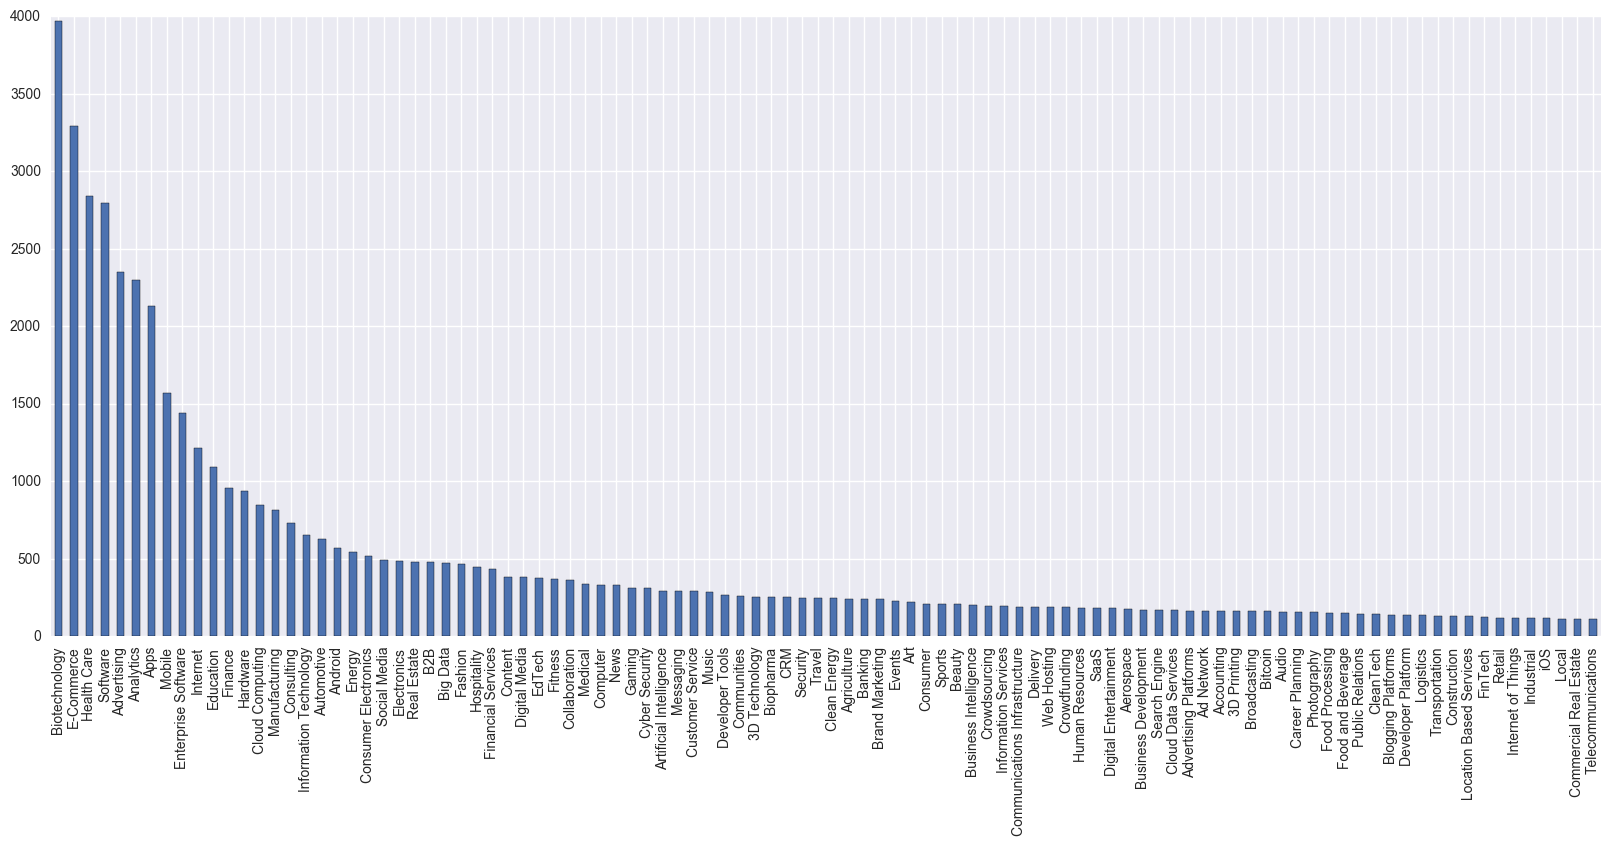

In [21]:
lstm_data['label'].value_counts()[:100].plot(kind='bar',figsize = [20,8])

In [22]:
#remove labels with only 1 data point
rem_list = pd.DataFrame(lstm_data.groupby('label')['company_uuid'].count()).reset_index()

In [23]:
rem_list = list(rem_list.loc[rem_list.company_uuid < 1000,'label'])

In [24]:
len(rem_list)

590

In [25]:
lstm_data[~lstm_data.label.isin(rem_list)].shape

(24975, 5)

In [26]:
lstm_data = lstm_data[~lstm_data.label.isin(rem_list)]

## Clean Description Data

In [27]:
lstm_data['clean_description'] = lstm_data.description.apply(lambda x:  ' '.join(x.split()))

In [28]:
lstm_data['clean_description'] = lstm_data.clean_description.apply(lambda x:
                                                                   x.encode('ascii','ignore'))

## Split into Train and Test - Stratified sampling

In [29]:
lstm_data.head()

,company_uuid,company_name,short_description,description,label,clean_description
179,fe57be45-36ee-ed64-289a-a06ac3f10142,Fastudent,Fastudent is the largest education portal in I...,Our mission is to provide efficient and effect...,Education,Our mission is to provide efficient and effect...
180,c60619c7-d558-fa8b-1484-d7fa26f85238,Yellowdig,Social collaboration tool that brings real-tim...,Social Collaboration Tool that brings knowledg...,Education,Social Collaboration Tool that brings knowledg...
181,711e148e-f841-945f-15f5-c8709960be5f,Kidblog,Kidblog provides teachers with blogging tools ...,"Kidblog is built by teachers, for teachers, so...",Education,"Kidblog is built by teachers, for teachers, so..."
182,8e1a08a1-5bb3-fb54-cce7-01ed70a1d160,Chalk.com,Microsoft Office for K-12 Teachers,Chalk.com helps teachers and administrators ma...,Education,Chalk.com helps teachers and administrators ma...
183,f46c9511-93b0-a65c-abba-b4b23c4b8ed1,Everest Education,Everest Education is a education platform,Everest Education (E2) is a social enterprise ...,Education,Everest Education (E2) is a social enterprise ...


In [30]:
y = lstm_data.pop('label')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(lstm_data, list(y), test_size=0.2, random_state=7,stratify = y)

In [37]:
f = open(mypath + '/lstm-rnn/lstm_data.pickle','wb')
pickle.dump((X_train, X_test, y_train, y_test), f, -1)
f.close()